### Imports

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pickle

import tempfile
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError
from keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, TimeDistributed, Reshape
from tensorflow.keras.layers import BatchNormalization, Bidirectional, LSTM, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import os
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install sentence_transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 112.2 MB/s eta 0:00:00
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=0fc5dc0916fc9872008390b69b5ddea41c0b44d35f55fc54ca02d373ada1e3a6
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers


In [3]:
from sentence_transformers import util

In [4]:
def read_df_and_display_num_rows_columns(filepath):
    with open(filepath, "rb") as file:
      data = pickle.load(file)
    print(f"Reading file: {filepath}")
    print(f"number of rows: {data.shape[0]}")
    print(f"number of columns: {data.shape[1]}")
    return data

In [5]:
df_train = read_df_and_display_num_rows_columns("/content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/train.pickle")
df_val = read_df_and_display_num_rows_columns("/content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/validation.pickle")
df_test = read_df_and_display_num_rows_columns("/content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/test.pickle")

Reading file: /content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/train.pickle
number of rows: 549350
number of columns: 6
Reading file: /content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/validation.pickle
number of rows: 9842
number of columns: 6
Reading file: /content/drive/MyDrive/ml-project-data-try/snli-sbert-dataset/test.pickle
number of rows: 9824
number of columns: 6


In [6]:
df_train.head()

,premise,hypothesis,label,premise_embedded,hypothesis_embedded,cosine_score
0,person horse jumps broken airplane,person training horse competition,neutral,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.050083168, 0.020744428, 0.006436512, -0.00...",0.387597
1,person horse jumps broken airplane,person diner ordering omelette,contradiction,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[0.01991658, 0.08336658, 0.05666334, -0.005686...",0.048144
2,person horse jumps broken airplane,person outdoors horse,entailment,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.015296373, 0.051944993, 0.06472147, -0.013...",0.514768
3,children smiling waving camera,smiling parents,neutral,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.038321618, 0.09435368, 0.0064652245, 0.039...",0.594589
4,children smiling waving camera,children present,entailment,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.018334052, 0.032883544, -0.014544778, 0.03...",0.569901


In [7]:
output_dimension = 384
lstm_units = 128
trainable = False #we do not want weights of the embedding layer to be updated during the training process
hidden_size = 128

In [8]:
# Parameters
L2 = 4e-6
DROPOUT = 0.2
LEARNING_RATE = 0.01
RHO = 0.9
EPSILON = 1e-08
DECAY = 0.0

CATEGORIES = 3
BATCH_SIZE = 512
TRAINING_EPOCHS = 25

PATIENCE = 5

In [9]:
def get_needed_data_columns(df):
  selected_columns = ['premise_embedded', 'hypothesis_embedded', 'cosine_score']
  new_df = df[selected_columns]
  return new_df

In [10]:
processed_train_data = get_needed_data_columns(df_train)
processed_train_data.head()

,premise_embedded,hypothesis_embedded,cosine_score
0,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.050083168, 0.020744428, 0.006436512, -0.00...",0.387597
1,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[0.01991658, 0.08336658, 0.05666334, -0.005686...",0.048144
2,"[-0.010034064, 0.0028005873, 0.0631274, 0.0080...","[-0.015296373, 0.051944993, 0.06472147, -0.013...",0.514768
3,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.038321618, 0.09435368, 0.0064652245, 0.039...",0.594589
4,"[-0.021928668, 0.06378024, 0.017834725, -0.032...","[-0.018334052, 0.032883544, -0.014544778, 0.03...",0.569901


In [12]:
processed_val_data = get_needed_data_columns(df_val)
processed_val_data.head()

,premise_embedded,hypothesis_embedded,cosine_score
0,"[0.0042251493, -0.003406235, -0.0019028404, 0....","[0.024690624, 0.09049612, 0.030129503, -0.0052...",0.583258
1,"[0.0042251493, -0.003406235, -0.0019028404, 0....","[-0.07236776, -0.020317988, -0.034565713, 0.02...",0.763924
2,"[0.0042251493, -0.003406235, -0.0019028404, 0....","[0.035375293, 0.042607836, -0.0109004835, 0.00...",0.069606
3,"[-0.08395465, 0.033306517, 0.05497519, -0.0349...","[-0.085580505, 0.06142286, 0.04118396, -0.0191...",0.753461
4,"[-0.08395465, 0.033306517, 0.05497519, -0.0349...","[-0.035818074, 0.0477772, 0.06401619, -0.03154...",0.595102


In [13]:
import tensorflow as tf

def cosine_similarity_loss(y_true, y_pred):
    y_true_normalized = tf.nn.l2_normalize(y_true, axis=-1)
    y_pred_normalized = tf.nn.l2_normalize(y_pred, axis=-1)
    similarity = tf.reduce_sum(tf.multiply(y_true_normalized, y_pred_normalized), axis=-1)
    loss = 1 - similarity
    return loss

In [15]:
def BL_model_train(train_data):
    BiLSTM = Bidirectional(LSTM(lstm_units))
    translation = TimeDistributed(Dense(output_dimension, activation='relu'))
    
    premise = Input(shape=(384,), dtype='float32')
    hypothesis = Input(shape=(384,), dtype='float32')

    premise_reshaped = Reshape((1, 384))(premise)
    hypothesis_reshaped = Reshape((1, 384))(hypothesis)

    premise_timeDistributed = translation(premise_reshaped)
    hypothesis_timeDistributed = translation(hypothesis_reshaped)
    
    premise_BiLSTM = BiLSTM(premise_timeDistributed)
    hypothesis_BiLSTM = BiLSTM(hypothesis_timeDistributed)
    
    premise_normalized = BatchNormalization()(premise_BiLSTM)
    hypothesis_normalized = BatchNormalization()(hypothesis_BiLSTM)
    
    train_input = concatenate([premise_normalized, hypothesis_normalized])
    train_input = Dropout(0.2)(train_input)
    
    for i in range(3):
        train_input = Dense(2 * hidden_size, activation='relu', kernel_regularizer=l2(4e-6))(train_input)
        train_input = Dropout(0.2)(train_input)
        train_input = BatchNormalization()(train_input)
    
    prediction = Dense(1, activation='linear')(train_input)  # Linear activation for regression
    
    model = Model(inputs=[premise, hypothesis], outputs=[prediction])
    optimizer = Adam(learning_rate=0.01)

    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mae'])

    # model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy', 'mse'])

    # model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    model.summary()
    
    return model


In [16]:
tensor_premise = tf.convert_to_tensor(tf.constant(processed_train_data['premise_embedded'].tolist()))
tensor_hypothesis = tf.convert_to_tensor(tf.constant(processed_train_data['hypothesis_embedded'].tolist()))
tensor_label = tf.convert_to_tensor(tf.constant(processed_train_data['cosine_score'].tolist()))

In [17]:
val_premise = tf.convert_to_tensor(tf.constant(processed_val_data['premise_embedded'].tolist()))
val_hypothesis = tf.convert_to_tensor(tf.constant(processed_val_data['hypothesis_embedded'].tolist()))
val_label = tf.convert_to_tensor(tf.constant(processed_val_data['cosine_score'].tolist()))

In [18]:
print("Training model")

model = BL_model_train(processed_train_data)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=PATIENCE, verbose=1, factor=0.5, min_lr=0.00001)
_, tmpfn = tempfile.mkstemp()
model_checkpoint = ModelCheckpoint(tmpfn, save_best_only=True, save_weights_only=True)
callbacks = [model_checkpoint, learning_rate_reduction]

# Train model
history = model.fit(x=[tensor_premise, tensor_hypothesis], y=tensor_label, batch_size=BATCH_SIZE, epochs=TRAINING_EPOCHS, validation_data=([val_premise, val_hypothesis], val_label), callbacks=callbacks)

# Restore the best found model during validation
model.load_weights(tmpfn)

Training model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 384)]        0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 384)       0           ['input_1[0][0]']                
                                                                                                  
 reshape_1 (Reshape)            (None, 1, 384)       0           ['input_2[0][0]']                
                                                                               

In [19]:
def plot_model_training(hist):
  """Function to plot accuracy and loss for iterations for the training and validation data set of the model
     Args:
       model: trained model"""
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  # Plot accuracy
  ax1.plot(hist.history['mae'])
  ax1.plot(hist.history['val_mae'])
  ax1.set_title('Model MAE')
  ax1.set_ylabel('MAE')
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation'], loc='upper right')

  # Plot loss
  ax2.plot(hist.history['loss'])
  ax2.plot(hist.history['val_loss'])
  ax2.set_title('Model Loss')
  ax2.set_ylabel('Loss')
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'], loc='upper right')

  plt.show()

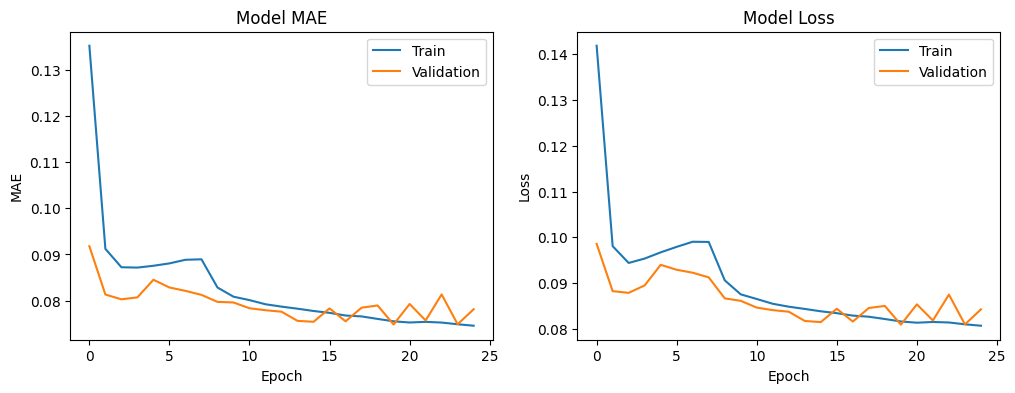

In [20]:
plot_model_training(history)

In [21]:
# Save the model as h5 file
model.save("/content/drive/MyDrive/ml-project-data-try/trained-models/BiLSTM/STS-BiLSTM.h5")